In [160]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd

# get helper functions
from helper_functions import *

In [161]:
# set the random seed
np.random.seed(235)

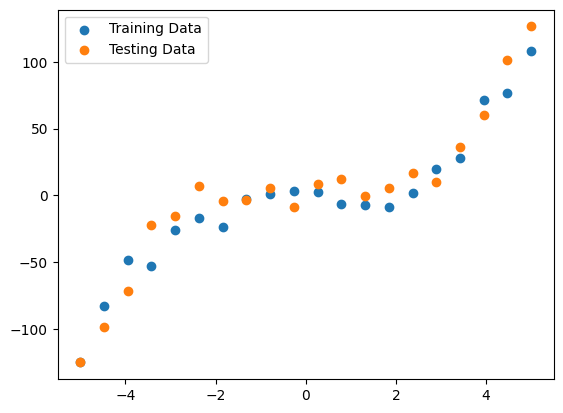

In [162]:
# generate training data
x_train, y_train = generate_data(20, 0, 9)
# generate test data
x_test, y_test = generate_data(20, 0, 9)

# plot the training data and testing data
plt.scatter(x_train, y_train, label='Training Data')
plt.scatter(x_test, y_test, label='Testing Data')
plt.legend()
plt.show()

In [163]:
# Normalize the data between [0,1]
x_train_norm = (x_train - np.mean(x_train)) / np.std(x_train)
y_train_norm = (y_train - np.mean(y_train)) / np.std(y_train)
x_test_norm = (x_test - np.mean(x_train)) / np.std(x_train)
y_test_norm = (y_test - np.mean(y_train)) / np.std(y_train)

In [164]:
# define the number of layers, number of neurons in each layern_layers = 1
n_units = 100
input_dim = 1 # considering that the input is implemented in one batch
output_dim = 1
# define the observation error
var_v = 9 / np.var(y_train) # normalized error

## Initialize the weights and biases

In [165]:
# Initialize the weights 
var_w1 =  np.diag(np.eye(n_units))
var_w2 = np.diag((1/n_units) * np.eye(n_units)) # TODO: check dimensions

mu_w1 = np.random.normal(0, 1, (n_units, input_dim))
mu_w2 = np.random.normal(0, (np.sqrt(1/n_units)), (n_units, output_dim))

# Initialize the biases
var_b1 =  np.diag(np.eye(n_units))
var_b2 = (1/n_units) * np.ones((output_dim, 1)) #TODO: check dimensions

mu_b1 = np.random.normal(0, 1, (n_units, input_dim))
mu_b2 = np.random.normal(0, np.sqrt((1/n_units)), (output_dim, 1))

# print size of the weights and biases
print('mu_w1:', mu_w1.shape)
print('mu_w2:', mu_w2.shape)
print('mu_b1:', mu_b1.shape)
print('mu_b2:', mu_b2.shape)

mu_w1: (100, 1)
mu_w2: (100, 1)
mu_b1: (100, 1)
mu_b2: (1, 1)


## Forward Pass

In [166]:
# Perform the forward pass from input to hidden layer
mu_z = mu_w1 * x_train[0] + mu_b1
var_z = var_w1 * x_train_norm[0]**2 + var_b1 #TODO: fix notation
cov_z_w = x_train[0] * var_w1
cov_z_b = var_b1

# print the size of the mean and variance of the hidden layer
print('mu_z:', mu_z.shape)
print('var_z:', var_z.shape)
print('cov_z_w:', cov_z_w.shape)
print('cov_z_b:', cov_z_b.shape)

mu_z: (100, 1)
var_z: (100,)
cov_z_w: (100,)
cov_z_b: (100,)


In [167]:
# Calculate the diagonal Jacobian matrix of the Relu transformation
J = relu_derivative(mu_z)
J = np.diag(J.flatten())
mu_a = J @ mu_z
var_a = J @ var_z @ J.T 
cov_a_w = J @ cov_z_w
cov_a_b = J @ cov_z_b

# print the size of the mean and variance of the hidden layer
print('mu_a:', mu_a.shape)
print('var_a:', var_a.shape)
print('cov_a_w:', cov_a_w.shape)
print('cov_a_b:', cov_a_b.shape)

mu_a: (100, 1)
var_a: (100,)
cov_a_w: (100,)
cov_a_b: (100,)


In [168]:
# now perform the forward pass from the hidden layer to the output layer
mu_z0 = mu_w2.T @ mu_a + mu_b2
var_z0 = var_w2.T @ var_a + var_w2.T @ mu_a**2 + var_a @ mu_w2**2 + var_b2 #TODO: fix notation
cov_z0_w = var_w2.T @ mu_a
cov_z0_b = var_b2

# print the size of the mean and variance of the hidden layer
print('mu_z0:', mu_z0.shape)
print('var_z0:', var_z0.shape)
print('cov_z0_w:', cov_z0_w.shape)
print('cov_z0_b:', cov_z0_b.shape)

mu_z0: (1, 1)
var_z0: (1, 1)
cov_z0_w: (1,)
cov_z0_b: (1, 1)


In [169]:
# get y
mu_y = mu_z0
var_y = var_z0 + var_v

# print the size of the mean and variance of the hidden layer
print('mu_y:', mu_y.shape)
print('var_y:', var_y.shape)

mu_y: (1, 1)
var_y: (1, 1)


## Backward Pass

In [170]:
# infer z0 after having observed y given that y = z0 + v
cov_y_z0 = var_z0
mu_z0_inf = mu_z0 + cov_y_z0.T @ np.linalg.inv(var_y) @ (y_train_norm[0] - mu_y)
var_z0_inf = var_z0 - cov_y_z0.T @ np.linalg.inv(var_y) @ cov_y_z0
#TODO diagonals
# print the size of the mean and variance of the hidden layer
print('mu_z0_inf:', mu_z0_inf.shape)
print('var_z0_inf:', var_z0_inf.shape)

mu_z0_inf: (1, 1)
var_z0_inf: (1, 1)


In [171]:
# apply one backward pass for TAGI from the output layer to the hidden layer
cov_zplus_z = var_z @ J.T @ mu_w2  #TODO: check formulation
Jz = cov_zplus_z @ np.linalg.inv(var_z0) 
mu_post_z = mu_z + Jz @ (mu_z0_inf - mu_z0) #TODO: transpose Jz
var_post_z = var_z + Jz @ (var_z0_inf-var_z0) @ Jz.T

In [172]:
# apply one backward pass for TAGI from the output layer to the weights and biases
Jw2 = cov_z0_w @ np.linalg.inv(var_z0)
Jb2 = cov_z0_b @ np.linalg.inv(var_z0)

mu_post_w2 = mu_w2 + Jw2 @ (mu_z0_inf - mu_z0)
var_post_w2 = var_w2 + Jw2 @ (var_z0_inf - var_z0) @ Jw2.T

mu_post_b2 = mu_b2 + Jb2 @ (mu_z0_inf - mu_z0)
var_post_b2 = var_b2 + Jb2 @ (var_z0_inf - var_z0) @ Jb2.T

In [173]:
Jw2

array([0.11874653])

In [174]:
# apply one backward pass for TAGI from the output layer to the weights and biases
Jw1 = cov_z_w / var_z
Jb1 = cov_z_b / var_z

mu_post_w1 = mu_w1 + Jw1 @ (mu_post_z - mu_z)
var_post_w1 = var_w1 + Jw1 @ (var_post_z - var_z) @ Jw1.T

mu_post_b1 = mu_b2 + Jb1 @ (mu_post_z - mu_z)
var_post_b1 = var_b1 + Jb1 @ (var_post_z - var_z) @ Jb1.T

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [175]:
Jw1

array([-1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34615385,
       -1.34615385, -1.34615385, -1.34615385, -1.34615385, -1.34